In [1]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import jax
import matplotlib.pyplot as plt

import src.sdes.sde_ornstein_uhlenbeck as ou
from src.sdes import sde_utils, time
from src import plotting

In [2]:
t_start = 0.
T = 1.
x0 = (5.,)
y = (0.,)
N = 50
num_trajectories = 100


key =  jr.PRNGKey(1)
traj_keys = jax.random.split(key, num_trajectories)

In [3]:
# time_grid = time.grid(t_start=t_start, T=T ,N=N)
# drift, diffusion = ou.vector_fields()
# 
# vary_x0_nonhitters = jax.random.uniform(jax.random.split(key, 2)[0], (num_trajectories, 1), minval=1.5, maxval=1.8)
# # vary_x0 = jnp.concatenate([vary_x0, jnp.asarray((2.704,))[..., None]])
# trajectories_none = jax.vmap(sde_utils.solution, (0, None, 0, None, None))(traj_keys, time_grid, vary_x0_nonhitters, drift, diffusion)
# 
# vary_x0 =jax.random.uniform(jax.random.split(key, 2)[0], (num_trajectories, 1), minval=2.5, maxval=3)
# trajectories = jax.vmap(sde_utils.solution, (0, None, 0, None, None))(traj_keys, time_grid, vary_x0, drift, diffusion)
# 
# for traj in trajectories_none:
#     plt.plot(time_grid, traj, color="C1")
# 
# for traj in trajectories:
#     plt.plot(time_grid, traj, color="C0")
# plt.scatter(1.0, 1.0, color="C2")
# # plt.scatter(0.0, 2.704)
# plt.title("forward")
# plt.show()

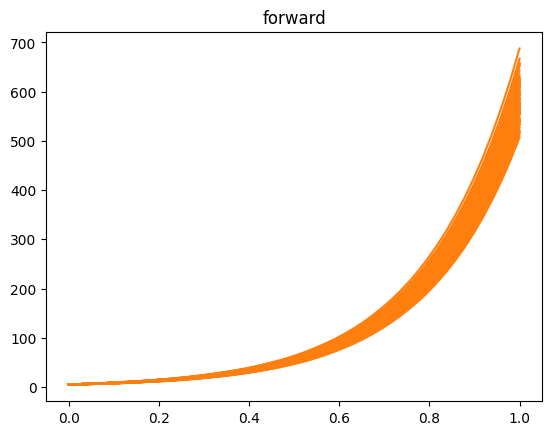

In [4]:
time_grid = time.grid(t_start=t_start, T=T ,N=N)
drift, diffusion = ou.vector_fields()


trajectories = jax.vmap(sde_utils.solution, (0, None, None, None, None))(traj_keys, time_grid, x0, drift, diffusion)

for traj in trajectories:
    plt.plot(time_grid, traj, color="C1")
# plt.ylim((0, 10))
plt.title("forward")
plt.show()

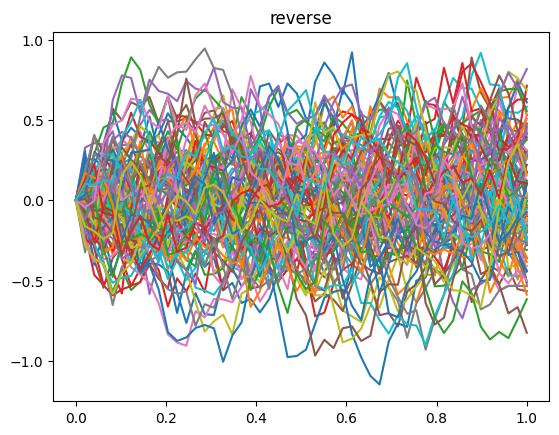

[0.41410556]


In [5]:
rev_keys = jax.random.split(key, num_trajectories)
drift_rev, diffusion_rev = ou.vector_fields_reverse()
rev = jax.vmap(sde_utils.solution, (0, None, None, None, None))(traj_keys, time_grid, y, drift_rev, diffusion_rev)

for traj in rev:
    plt.plot(time_grid, traj)
plt.title("reverse")
plt.show()
print(rev[0][-1])

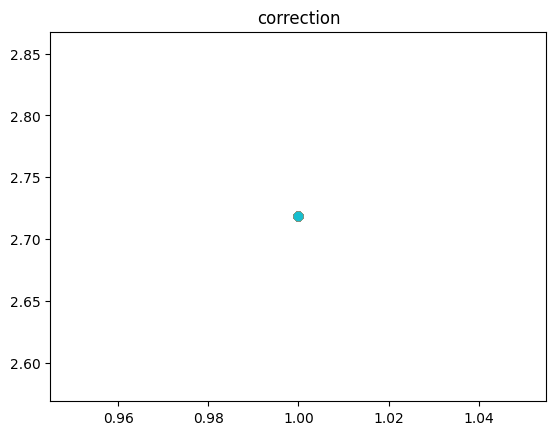

In [6]:
data_fn = ou.data_reverse(y, T, N)
ts, rev, corr = data_fn(rev_keys)

for correct in corr:
    plt.scatter(ts[0, -1], correct)
plt.title("correction")
plt.show()

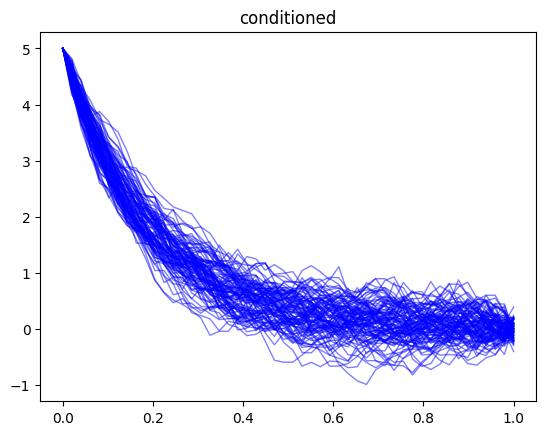

In [7]:
cond_keys = jax.random.split(key, num_trajectories)
score_fn = partial(ou.score, T=T, y=jnp.asarray(y))
cond = jax.vmap(sde_utils.conditioned, (0, None, None, None, None, None))(traj_keys, time_grid, x0, score_fn, drift, diffusion)

linewidth=1.
alpha=0.5

time_partial = time_grid[::1]
cond_partial = cond[:, ::1]

for traj in cond_partial:
    plt.plot(time_partial, traj, linewidth=linewidth, alpha=alpha, color="blue")
plt.title("conditioned")
plt.show()


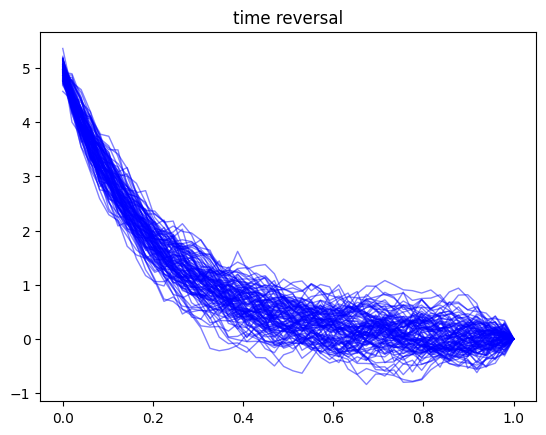

In [8]:
score_fn_fw = partial(ou.score_forward, 0., jnp.asarray(x0))

time_rev = jax.vmap(sde_utils.backward, (0, None, None, None, None, None))(traj_keys, time_grid, y, score_fn_fw, drift, diffusion)[:, ::-1]

time_rev_partial = time_rev[:, ::1]
time_grid_partial = time_grid[::1]



for traj in time_rev_partial:
    plt.plot(time_grid_partial[:], traj[:], linewidth=linewidth, alpha=alpha, color="blue")
plt.title("time reversal")
plt.show()
